# Generative Adversarial Network
In this notebook we'll be building a model to generate handwritten digets using training data from [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

### Import Tensorflow & Download data

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Build Network

#### Inputs

In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

#### Generator

In [4]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        g_h1 = tf.layers.dense(z, n_units, activation=None)
        g_h1 = tf.maximum(alpha * g_h1, g_h1)

        # Logits
        g_logits = tf.layers.dense(g_h1, input_size, activation=None)
        g_out = tf.tanh(g_logits)
        
        return g_out

#### Discriminator

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        d_h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        d_h1 = tf.maximum(alpha * d_h1, d_h1)
        
        # Logits
        d_logits = tf.layers.dense(d_h1, 1, activation=None)
        d_out = tf.sigmoid(d_logits)
        
        return d_out, d_logits

#### Hyper Parameters

In [6]:
# Size of input image discriminator
input_size = 784
z_size = 100
# Sizes of hidden layers generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing
smooth = 0.1

#### Define Model

In [7]:
tf.reset_default_graph()

input_real, input_z = model_inputs(input_size, z_size)

# Generator
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# Discriminator
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

#### Cost Functions

In [8]:
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

#### Optimizers

In [9]:
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

### Training

In [10]:
batch_size = 100
epochs = 100
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to Discriminator
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images * 2 - 1
            
            # Sample random noise for Generator
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Optimize!
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            
            _ = sess.run(g_train_opt, feed_dict={
                input_z: batch_z
            })
            
        # At the end of each epoch, get the losses and print them out
        d_train_loss = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        g_train_loss = sess.run(g_loss, {input_z: batch_z})
        
        print(
            "Epoch {:2d}/{}...".format(e+1, epochs),
            "Discriminator Loss: {:.4f}...".format(d_train_loss),
            "Generator Loss: {:.4f}".format(g_train_loss))
        
        # Save Losses to view after training
        losses.append((d_train_loss, g_train_loss))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(g_model, feed_dict={input_z: sample_z})
        
        samples.append(gen_samples)
        saver.save(sess, './gan-checkpoints/generator.ckpt')

Epoch  1/10... Discriminator Loss: 1.6296... Generator Loss: 0.9629
Epoch  2/10... Discriminator Loss: 0.5349... Generator Loss: 3.1066
Epoch  3/10... Discriminator Loss: 0.7016... Generator Loss: 2.1844
Epoch  4/10... Discriminator Loss: 0.5467... Generator Loss: 2.4259
Epoch  5/10... Discriminator Loss: 1.2945... Generator Loss: 1.2677
Epoch  6/10... Discriminator Loss: 1.1400... Generator Loss: 5.6365
Epoch  7/10... Discriminator Loss: 0.7268... Generator Loss: 4.8172
Epoch  8/10... Discriminator Loss: 0.7181... Generator Loss: 3.1698
Epoch  9/10... Discriminator Loss: 0.8221... Generator Loss: 3.8326
Epoch 10/10... Discriminator Loss: 0.7879... Generator Loss: 2.0790


### Training Loss Over time

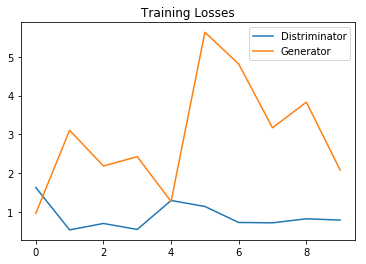

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Distriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Samples

In [12]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    
    return fig, axes

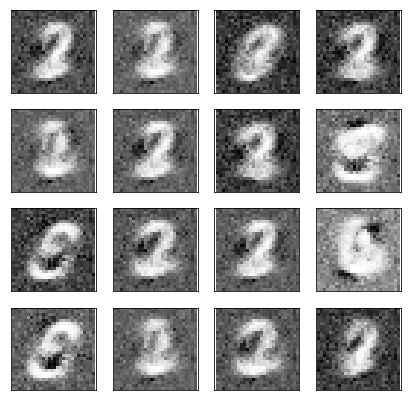

In [13]:
_ = view_samples(-1, samples)